# This file tunes the final Random Forest Model

In [485]:
import pandas as pd
import numpy as np
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn_evaluation import plot
from matplotlib import pyplot as plt

from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')

w = pd.read_csv("../Data/vectorizedWords.csv").to_numpy()
df = pd.read_csv("../Data/2.5k_reviews.csv")

## 1.) Put Vectorized features into df as it was saved separately

In [486]:
df["vectorization"] = [i for i in w]

## 2.) Undersample as data is unbalanced, ratio is approximately 10:8 for negative:positive

In [663]:
num0s = df.sentiment.value_counts()[0] # Get number of 0s (negative reviews)
subset_index = df[df.sentiment == 1].sample(int(df.shape[0] - num0s*1.8)).index # Obtain positive reviews indexes to be dropped
subset = df.drop(subset_index).reset_index(drop=True) # Drop extra positive reviews for undersampling
print("Number of negative reviews: "+str(len(subset)-subset.sentiment.sum())+"; Number of positive reviews: "+str(subset.sentiment.sum()))

Number of negative reviews: 701; Number of positive reviews: 561


## 3.) Train and run best Random Forest Classifier Model

In [ ]:
y = subset.sentiment.values
X = subset.vectorization.values
X_train = np.stack(X, axis=0) # Expand the array for model

In [678]:
# Initialize RF model with 500 trees, a max depth of 10 (not too much as it will overfit) and max_feature of 2. Other parameters were tested to find the best ones.
pipeline_rf = RandomForestClassifier(oob_score=True,n_estimators=500,max_depth=10,max_features=2,criterion='entropy',n_jobs=-1)
pipeline_rf = pipeline_rf.fit(X_train, y)
y_pred_train_rf = pipeline_rf.predict(X_train)

# Reported average results will be shown in 05_testPKL.ipynb
print(classification_report(y,y_pred_train_rf))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       701
           1       0.98      0.96      0.97       561

    accuracy                           0.97      1262
   macro avg       0.97      0.97      0.97      1262
weighted avg       0.97      0.97      0.97      1262


In [685]:
joblib.dump(pipeline_rf,'../Data/best_model.pkl') # Save model as pkl file

['best_model.pkl']

## 4.) Test model on 100 N sample from entire dataset 

In [739]:
test_case = df.sample(100, random_state=1)
y_mod = test_case.sentiment.values
X_mod = test_case.vectorization.values
X_mod = np.stack(X_mod, axis=0) # Expand the array for model
y_pred_mod = pipeline_rf.predict(X_mod)
print(classification_report(y_mod,y_pred_mod))

              precision    recall  f1-score   support

           0       0.58      0.97      0.73        29
           1       0.98      0.72      0.83        71

    accuracy                           0.79       100
   macro avg       0.78      0.84      0.78       100
weighted avg       0.87      0.79      0.80       100

0.79


## 5.) Visualize results for 100N test using ROC curve

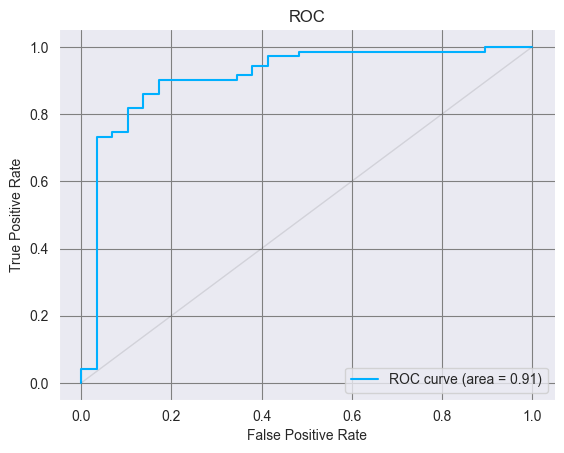

In [738]:
y_score = pipeline_rf.predict_proba(X_mod) # Predict estimates for all classes
roc = plot.ROC.from_raw_data(y_mod, y_score) # Using sklearn ROC plot function
plt.savefig('../Results/04_ROC.png'); # Save fig